In [1]:
library(randomForest())
library(caret)
library(ggplot2)
library(Metrics)
library(reshape2)

randomForest 4.7-1.1

Type rfNews() to see new features/changes/bug fixes.

Loading required package: ggplot2


Attaching package: 'ggplot2'


The following object is masked from 'package:randomForest':

    margin


Loading required package: lattice


Attaching package: 'Metrics'


The following objects are masked from 'package:caret':

    precision, recall




In [2]:
df <- read.csv("../../../Cleaned Datasets/rebate_cleaned.csv")
set.seed(42)

train_index <- createDataPartition(df$`Rebate.Amount..USD.`, p = 0.7, list = FALSE)

train_data <- df[train_index, ]
test_data <- df[-train_index, ]

train_data$`Rebate.Amount..USD.` <- factor(train_data$`Rebate.Amount..USD.`)
test_data$`Rebate.Amount..USD.` <- factor(test_data$`Rebate.Amount..USD.`)

In [3]:
set.seed(42)

num_predictors <- length(names(train_data)) - 1
mtry_sqrt <- floor(sqrt(num_predictors))

model <- randomForest(`Rebate.Amount..USD.`  ~ ., data = train_data, ntree = 30, 
            mtry = mtry_sqrt, maxnodes=15, do.trace=TRUE)

print(model)
summary(model)

ntree      OOB      1      2      3      4
    1:  10.10% 22.63%  0.12% 15.01%  2.89%
    2:   8.12% 19.04%  0.11%  9.43%  4.01%
    3:   6.30% 14.95%  0.09%  6.26%  3.84%
    4:   7.17% 14.71%  5.35%  5.43%  3.21%
    5:   5.90% 11.60%  3.57%  5.17%  3.27%
    6:   5.48%  9.98%  3.54%  5.21%  3.20%
    7:   5.51%  8.09%  2.41%  5.03%  6.53%
    8:   4.84%  7.47%  1.89%  4.56%  5.43%
    9:   4.46%  7.38%  1.53%  4.17%  4.76%
   10:   4.02%  6.70%  1.43%  4.17%  3.78%
   11:   3.87%  6.77%  1.04%  4.45%  3.22%
   12:   3.82%  6.87%  1.04%  4.40%  2.99%
   13:   3.78%  6.52%  0.59%  4.27%  3.75%
   14:   3.69%  6.72%  0.63%  4.18%  3.23%
   15:   3.70%  7.10%  1.04%  3.95%  2.73%
   16:   3.59%  7.48%  0.63%  3.99%  2.28%
   17:   3.55%  7.17%  0.59%  3.99%  2.46%
   18:   3.40%  6.81%  0.38%  3.99%  2.41%
   19:   3.46%  7.14%  0.27%  4.15%  2.28%
   20:   3.41%  7.41%  0.18%  4.10%  1.94%
   21:   3.51%  7.64%  0.16%  4.39%  1.85%
   22:   3.48%  7.23%  0.16%  4.39%  2.12%
   23:   3.

                Length Class  Mode     
call                7  -none- call     
type                1  -none- character
predicted       17756  factor numeric  
err.rate          150  -none- numeric  
confusion          20  -none- numeric  
votes           71024  matrix numeric  
oob.times       17756  -none- numeric  
classes             4  -none- character
importance          8  -none- numeric  
importanceSD        0  -none- NULL     
localImportance     0  -none- NULL     
proximity           0  -none- NULL     
ntree               1  -none- numeric  
mtry                1  -none- numeric  
forest             14  -none- list     
y               17756  factor numeric  
test                0  -none- NULL     
inbag               0  -none- NULL     
terms               3  terms  call     

In [4]:
predictions <- predict(model, test_data)
actual <- test_data$`Rebate.Amount..USD.`

In [5]:
conf_matrix <- confusionMatrix(predictions, actual)

predictions <- factor(predictions, levels = levels(test_data$`Rebate.Amount..USD.`))

cm <- confusionMatrix(predictions, test_data$`Rebate.Amount..USD.`)

precision <- cm$byClass[, 'Precision']
recall <- cm$byClass[, 'Recall']
f1 <- cm$byClass[, 'F1']
accuracy <- cm$overall['Accuracy']

precision <- precision[!is.na(precision)]
recall <- recall[!is.na(recall)]
f1 <- f1[!is.na(f1)]

avg_precision <- mean(precision)
avg_recall <- mean(recall)
avg_f1 <- mean(f1)

print(paste("Accuracy:", accuracy))
print(paste("Average Precision:", avg_precision))
print(paste("Average Recall:", avg_recall))
print(paste("Average F1 Score:", avg_f1))

[1] "Accuracy: 0.971871713985279"
[1] "Average Precision: 0.973337949286587"
[1] "Average Recall: 0.971871713985279"
[1] "Average F1 Score: 0.972098168012221"


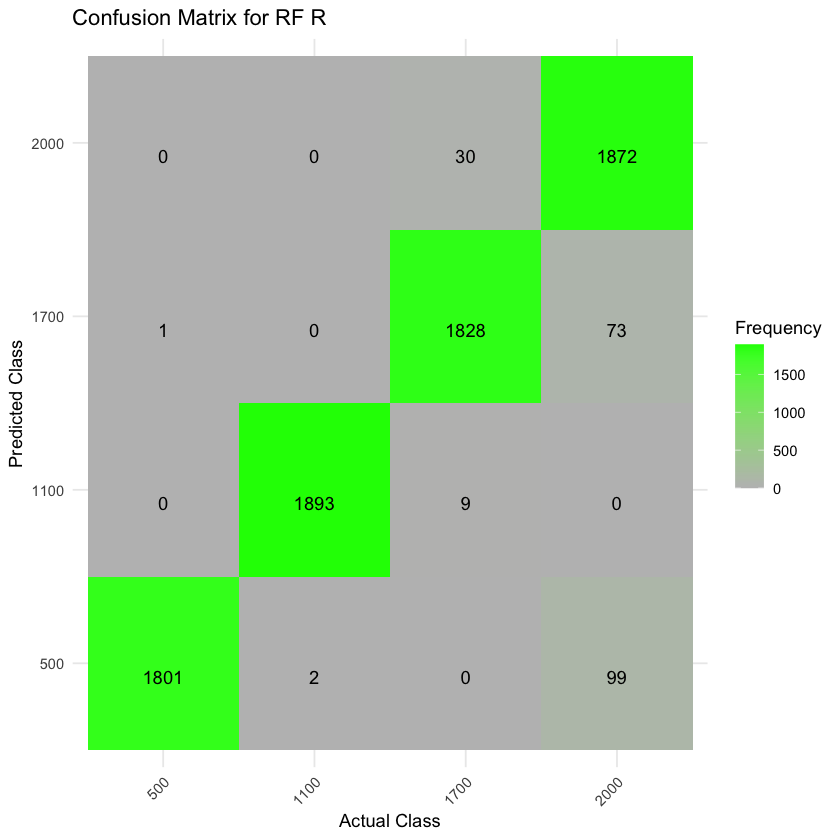

In [6]:
conf_mat <- as.matrix(conf_matrix$table)
conf_data <- as.data.frame(melt(conf_mat))
names(conf_data) <- c("Reference", "Prediction", "Frequency")

custom_labels <- c('500', '1100', '1700', '2000')

conf_data$Reference <- factor(conf_data$Reference, levels = unique(conf_data$Reference), labels = custom_labels)
conf_data$Prediction <- factor(conf_data$Prediction, levels = unique(conf_data$Prediction), labels = custom_labels)

 ggplot(conf_data, aes(x = Reference, y = Prediction, fill = Frequency)) +
    geom_tile() +
    geom_text(aes(label = Frequency), vjust = 1.5, color = "black") +
    scale_fill_gradient(low = "grey", high = "green") +
    labs(title = "Confusion Matrix for RF R", x = "Actual Class", y = "Predicted Class") +
    theme_minimal() +
    theme(axis.text.x = element_text(angle = 45, hjust = 1), axis.text.y = element_text(angle = 0)) + 
    scale_x_discrete(labels = custom_labels) +
    scale_y_discrete(labels = custom_labels)


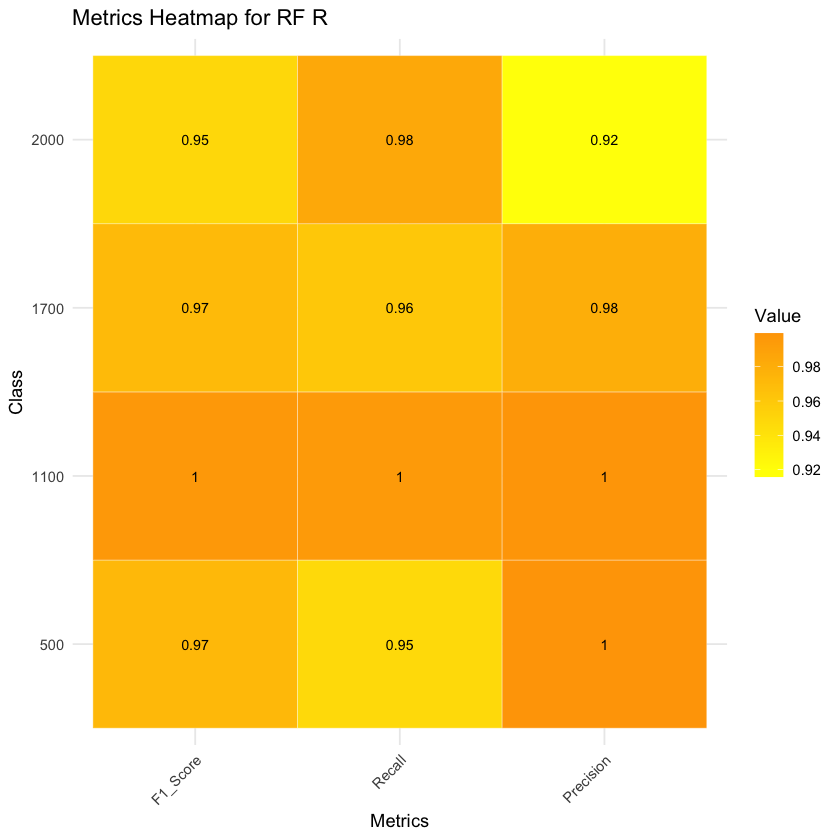

In [7]:
f1 <- cm[["byClass"]][ , "F1"]
recall <- cm[["byClass"]][ , "Recall"]
precision <- cm[["byClass"]][ , "Precision"]

metrics_df <- data.frame(Class = rownames(cm[["byClass"]]), F1_Score = f1, Recall = recall, Precision = precision)

metrics_melted <- melt(metrics_df, id.vars = "Class", variable.name = "Metric", value.name = "Value")

metrics_melted$Class <- factor(metrics_melted$Class, levels = unique(metrics_melted$Class))

custom_labels <- c('500','1100','1700','2000')

ggplot(metrics_melted, aes(x = Metric, y = Class, fill = Value, label = round(Value, 2))) +
  geom_tile(color = "white") +
  geom_text(color = "black", size = 3) +
  scale_fill_gradient(low = "yellow", high = "orange") +
  labs(title = "Metrics Heatmap for RF R", x = "Metrics", y = "Class") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) + 
  scale_y_discrete(labels = custom_labels) 